In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.nonparametric.smoothers_lowess import lowess
from AB_testing import *
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 10, 6

# Initializing two Variant objects (A and B)

In [2]:
# Parameters for our beta distribution prior
alpha = 4
beta = 100
conversion_rate_value = 10000

A = Variant(alpha, beta, conversion_rate_value)
B = Variant(alpha, beta, conversion_rate_value)

## Plotting our weakly informative prior
The distribution looks purple because it is a red distribution overlapping with a blue one.

(0.0, 20.0)

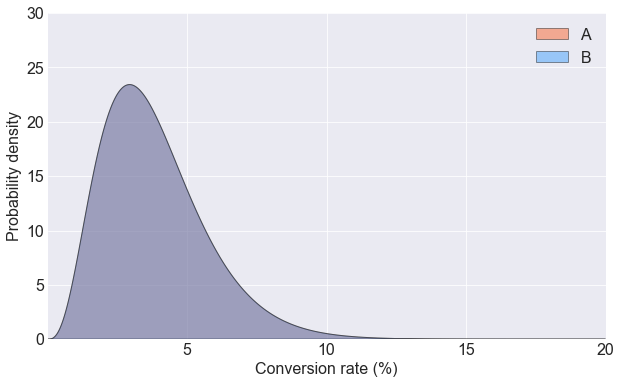

In [3]:
A.plot_conversion_dist('orangered')
B.plot_conversion_dist('dodgerblue')
plt.legend(['A', 'B'])
plt.ylim(0,30)
plt.xlim(0,20)

## Plotting it as a monetary lottery

([<matplotlib.axis.XTick at 0x7fc4b0a778b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

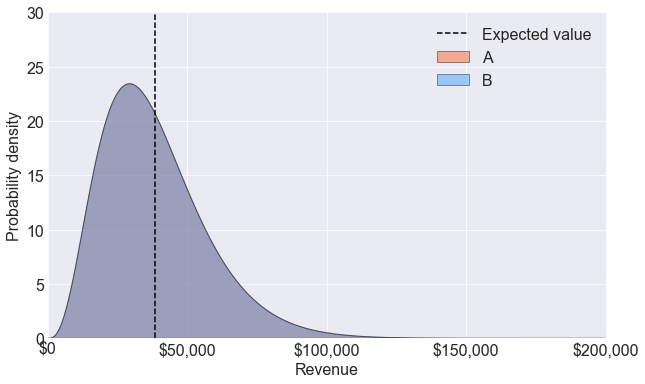

In [4]:
plt.axvline(A.expected_value, linestyle='--', color='k')
A.plot_value_dist('orangered')
B.plot_value_dist('dodgerblue')
plt.legend(['Expected value', 'A', 'B'])
plt.ylim(0,30)
plt.xlim(0,200000)
plt.xticks(np.linspace(0,200000, 5))

# Simulating an A/B test

In [5]:
# setting the seed to make the result repeatable
np.random.seed(3)
updated_value = simulate_test(A, B, test_sample_size=100, verbose=True)

Variant A: 11 conversions out of 100
Variant B: 2 conversions out of 100
A appears to be the better option


In [6]:
# Updating beliefs based on the test results
A.update_beliefs(test_sample_size=100, num_conversions=11)
B.update_beliefs(test_sample_size=100, num_conversions=2)

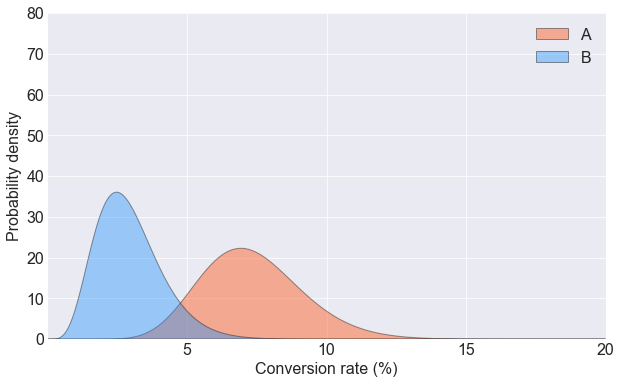

In [7]:
A.plot_conversion_dist('orangered')
B.plot_conversion_dist('dodgerblue')
plt.ylim(0,80)
plt.legend(['A', 'B'])

([<matplotlib.axis.XTick at 0x7fc4a08385b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

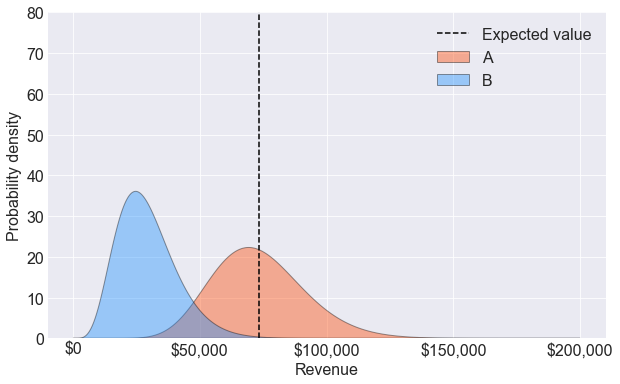

In [8]:
plt.axvline(updated_value, linestyle='--', color='k')
A.plot_value_dist('orangered')
B.plot_value_dist('dodgerblue')
plt.ylim(0,80)
plt.legend(['Expected value', 'A', 'B'])
plt.ylim(0,80)
plt.xticks(np.linspace(0,200000, 5))

## Reset objects and simulate another test

In [9]:
np.random.seed(30)
A = Variant(alpha, beta, conversion_rate_value)
B = Variant(alpha, beta, conversion_rate_value)
updated_value = simulate_test(A, B, test_sample_size=100, verbose=True, update_beliefs=True)

Variant A: 4 conversions out of 100
Variant B: 5 conversions out of 100
B appears to be the better option


([<matplotlib.axis.XTick at 0x7fc490223d00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

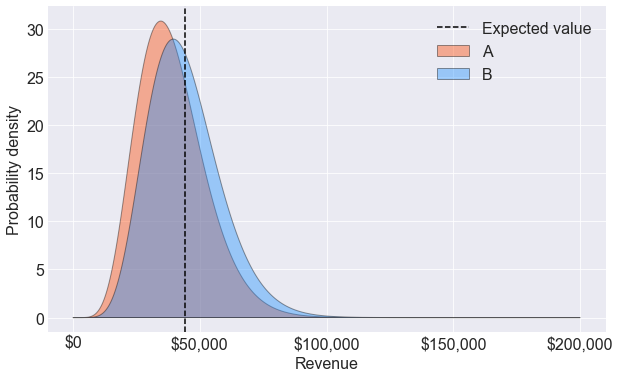

In [10]:
plt.axvline(updated_value, linestyle='--', color='k')
A.plot_value_dist('orangered')
B.plot_value_dist('dodgerblue')
plt.legend(['Expected value', 'A', 'B'])
plt.xticks(np.linspace(0,200000, 5))

# Compute value of information starting from the original prior

In [11]:
np.random.seed(0)
A = Variant(alpha, beta, conversion_rate_value)
B = Variant(alpha, beta, conversion_rate_value)
voi = calc_voi(A, B, test_sample_size=100)
print(voi)

100%|██████████| 10000/10000 [00:13<00:00, 722.22it/s]

7294.343891402721


# Value of information as a function of sample size, original prior

In [12]:
np.random.seed(46)
A = Variant(alpha, beta, conversion_rate_value)
B = Variant(alpha, beta, conversion_rate_value)

In [13]:
def voi_vs_sample_size(sample_sizes, A, B):
    voi_list = []
    for size in sample_sizes:
        voi_list.append(calc_voi(A, B, test_sample_size=size))
    return voi_list

In [14]:
sample_sizes = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500]
cost = 25*np.array(sample_sizes)

In [15]:
voi_list_original = voi_vs_sample_size(sample_sizes, A, B)
voc_original = calc_voc(A, B)

100%|██████████| 10000/10000 [00:13<00:00, 733.89it/s]


In [16]:
def make_plot(voi_list, sample_sizes, voc, cost):
    smooth_voi = lowess(voi_list, sample_sizes, return_sorted=False, frac=.25)
    
    fig, ax = plt.subplots()
    raw_points = ax.scatter(sample_sizes, voi_list, color='k', alpha=0.5)
    voc_line = ax.axhline(voc, color='k', linestyle='--')
    smooth_voi_line = ax.plot(sample_sizes, smooth_voi, color='green', linewidth=3)[0]
    cost_line = ax.plot(sample_sizes, cost, color='orangered', linewidth=3)[0]
    profit_region = ax.fill_between(sample_sizes, cost, smooth_voi, color='green', where=smooth_voi >= cost, alpha=0.2, interpolate=True)
    loss_region = ax.fill_between(sample_sizes, cost, smooth_voi, color='red', where=cost > smooth_voi, alpha=0.2, interpolate=True)
    ax.set_xlabel("Number of participants")
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax.legend([raw_points, smooth_voi_line, voc_line, cost_line, profit_region, loss_region],
               ["Raw MC results", "Smooth VOI", "Value of clairvoyance", "Cost", "Profit", "Loss"], 
               loc='upper left', frameon=True, ncol=2)
    ax.set_xlim(0,np.max(sample_sizes))
    ax.set_ylim(0, 15000)

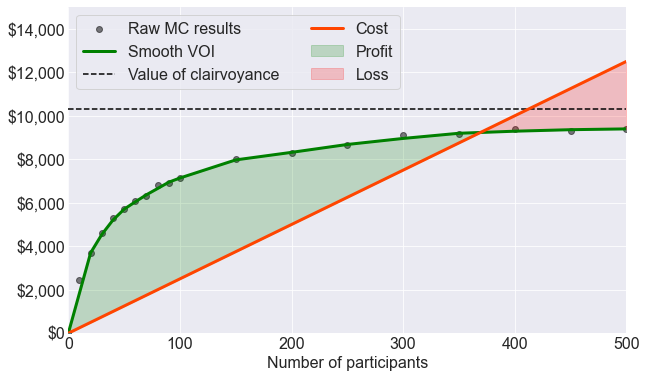

In [17]:
make_plot(voi_list_original, sample_sizes, voc_original, cost)

# Value of information as a function of sample size, "informed" prior

In [18]:
np.random.seed(113)
A = Variant(alpha, beta, conversion_rate_value)
B = Variant(alpha, beta, conversion_rate_value)
updated_value = simulate_test(A, B, test_sample_size=30, verbose=True, update_beliefs=True)

Variant A: 2 conversions out of 30
Variant B: 4 conversions out of 30
B appears to be the better option


([<matplotlib.axis.XTick at 0x7fc4a08ef0a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

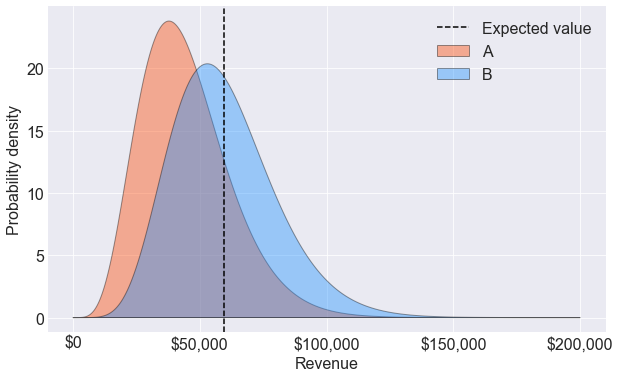

In [19]:
plt.axvline(updated_value, linestyle='--', color='k')
A.plot_value_dist('orangered')
B.plot_value_dist('dodgerblue')
plt.legend(['Expected value', 'A', 'B'])
plt.xticks(np.linspace(0,200000, 5))

In [20]:
voi_list_informed = voi_vs_sample_size(sample_sizes, A, B)
voc_informed = calc_voc(A, B)

100%|██████████| 10000/10000 [00:13<00:00, 737.05it/s]


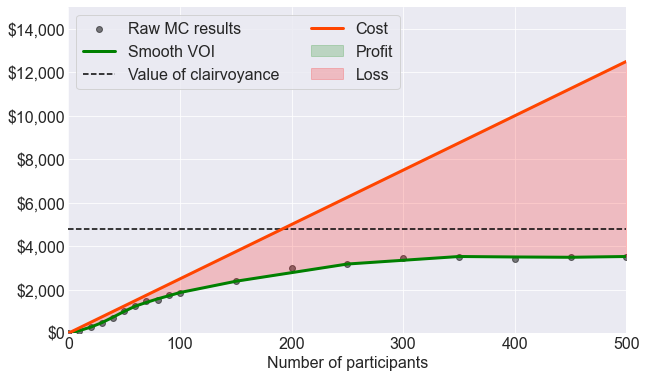

In [21]:
make_plot(voi_list_informed, sample_sizes, voc_informed, cost)